In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage

In [2]:
import sklearn
from sklearn.externals import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from rdkit.Chem import PandasTools
from rdkit.Chem import rdMolDescriptors

/Users/leela.dodda/anaconda3/envs/deepchem/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


## Load Library of compounds need to be screened

In [3]:
df = PandasTools.LoadSDF('drugbank_all_structures.sdf')

RDKit ERROR: [13:18:35] Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [13:18:35] ERROR: Could not sanitize molecule ending on line 21246
RDKit WARNING: [13:18:35] Warning: conflicting stereochemistry at atom 5 ignored.
RDKit WARNING: [13:18:35] Warning: conflicting stereochemistry at atom 5 ignored.
RDKit ERROR: [13:18:35] ERROR: Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [13:18:36] Explicit valence for atom # 13 Cl, 5, is greater than permitted
RDKit ERROR: [13:18:36] ERROR: Could not sanitize molecule ending on line 286901
RDKit ERROR: [13:18:36] ERROR: Explicit valence for atom # 13 Cl, 5, is greater than permitted
RDKit ERROR: [13:18:36] Explicit valence for atom # 39 N, 5, is greater than permitted
RDKit ERROR: [13:18:36] ERROR: Could not sanitize molecule ending on line 325689
RDKit ERROR: [13:18:36] ERROR: Explicit valence for atom # 39 N, 5, is greater than permitted
RDKit ERROR: [13:18:36] Explicit valence for atom #

In [4]:
df.MOLECULAR_WEIGHT = df.MOLECULAR_WEIGHT.astype(float)
df.ALOGPS_LOGP = df.ALOGPS_LOGP.astype(float)

In [5]:
df = df[df.MOLECULAR_WEIGHT<700]

In [6]:
df.describe()

,ALOGPS_LOGP,MOLECULAR_WEIGHT
count,9753.000000,9988.000000
mean,1.876587,333.300670
std,2.325390,131.932970
min,-4.210000,3.016000
25%,0.250000,238.282425
50%,2.100000,329.790500
75%,3.530000,420.207250
max,10.890000,698.896000


## Load ECFP based RF  Models for CAMK2A/B/D/G

In [17]:
screen = {'ECFP':{},'Pharm2D':{},'MACCS':{}}
screen['ECFP']['CAMK2G'] = joblib.load('models/RF-ECFP-pki/CAMK2G/finalized_model_CAMK2G_RandomStratified.sav')
screen['ECFP']['CAMK2D'] = joblib.load('models/RF-ECFP-pki/CAMK2D/finalized_model_CAMK2D_MaxMin.sav')
screen['ECFP']['CAMK2B'] = joblib.load('models/RF-ECFP-pki/CAMK2B/finalized_model_CAMK2B_MaxMin.sav')
screen['ECFP']['CAMK2A'] = joblib.load('models/RF-ECFP-pki/CAMK2A/finalized_model_CAMK2A_RandomStratified.sav')

In [8]:
df['ECFP_FP'] = [rdMolDescriptors.GetMorganFingerprintAsBitVect(mol,2,1024) for mol in df.ROMol]

In [ ]:
### Remove Compounds with molecular weight > 700, Maximum limit for kinases is 700

In [10]:
df['pki_G']= screen['ECFP']['CAMK2G'].predict(np.array(list(df.ECFP_FP)))
df['pki_D']= screen['ECFP']['CAMK2D'].predict(np.array(list(df.ECFP_FP)))
df['pki_B']= screen['ECFP']['CAMK2B'].predict(np.array(list(df.ECFP_FP)))
df['pki_A']= screen['ECFP']['CAMK2A'].predict(np.array(list(df.ECFP_FP)))

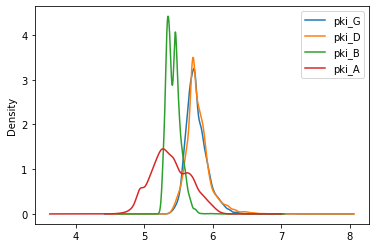

In [11]:
df[df.columns[-4:]].plot(kind='kde')

In [12]:
df['SelB'] = df.pki_G - df.pki_B
df['SelA'] = df.pki_G - df.pki_A
df['SelD'] = df.pki_G - df.pki_D

In [13]:
df = df.sort_values(['pki_G','SelA','SelB','SelD'],ascending=False)

In [14]:
df['AvgABSel'] = (df.SelA + df.SelB)*0.5

Text(0.5, 1.0, 'Morgan Fingerprint')

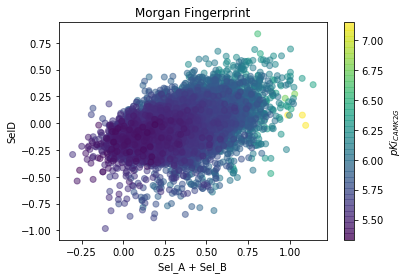

In [73]:
sc = plt.scatter(df.AvgABSel,df.SelD,c=list(df.pki_G),alpha=0.5)
plt.colorbar(sc,label='$pKi_{CAMK2G}$')
plt.xlabel('Sel_A + Sel_B')
plt.ylabel('SelD')
plt.title('Morgan Fingerprint')

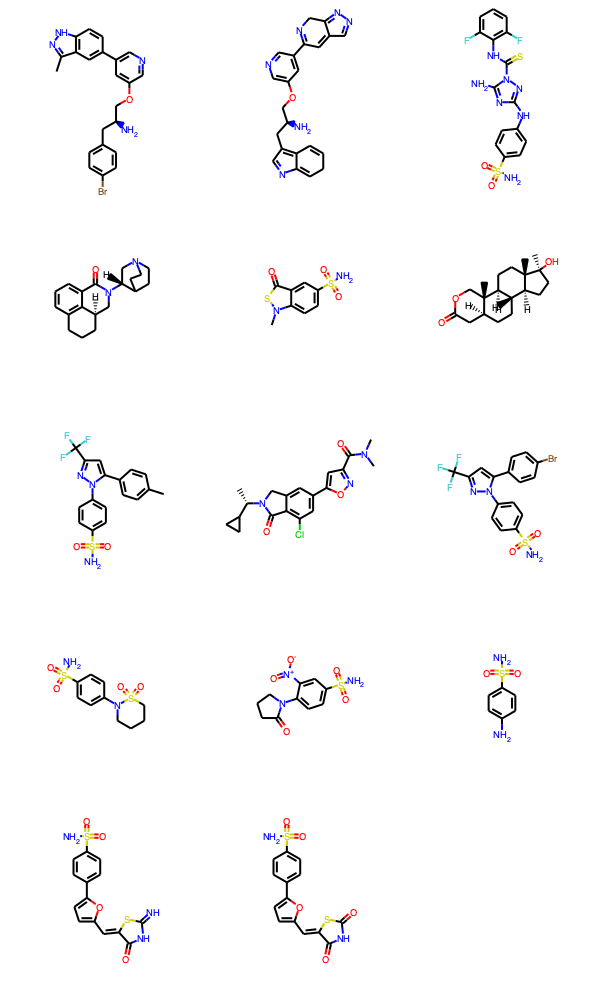

In [66]:
Draw.MolsToGridImage(list(df[(df.AvgABSel>1)&(df.SelD>0.0)].ROMol))

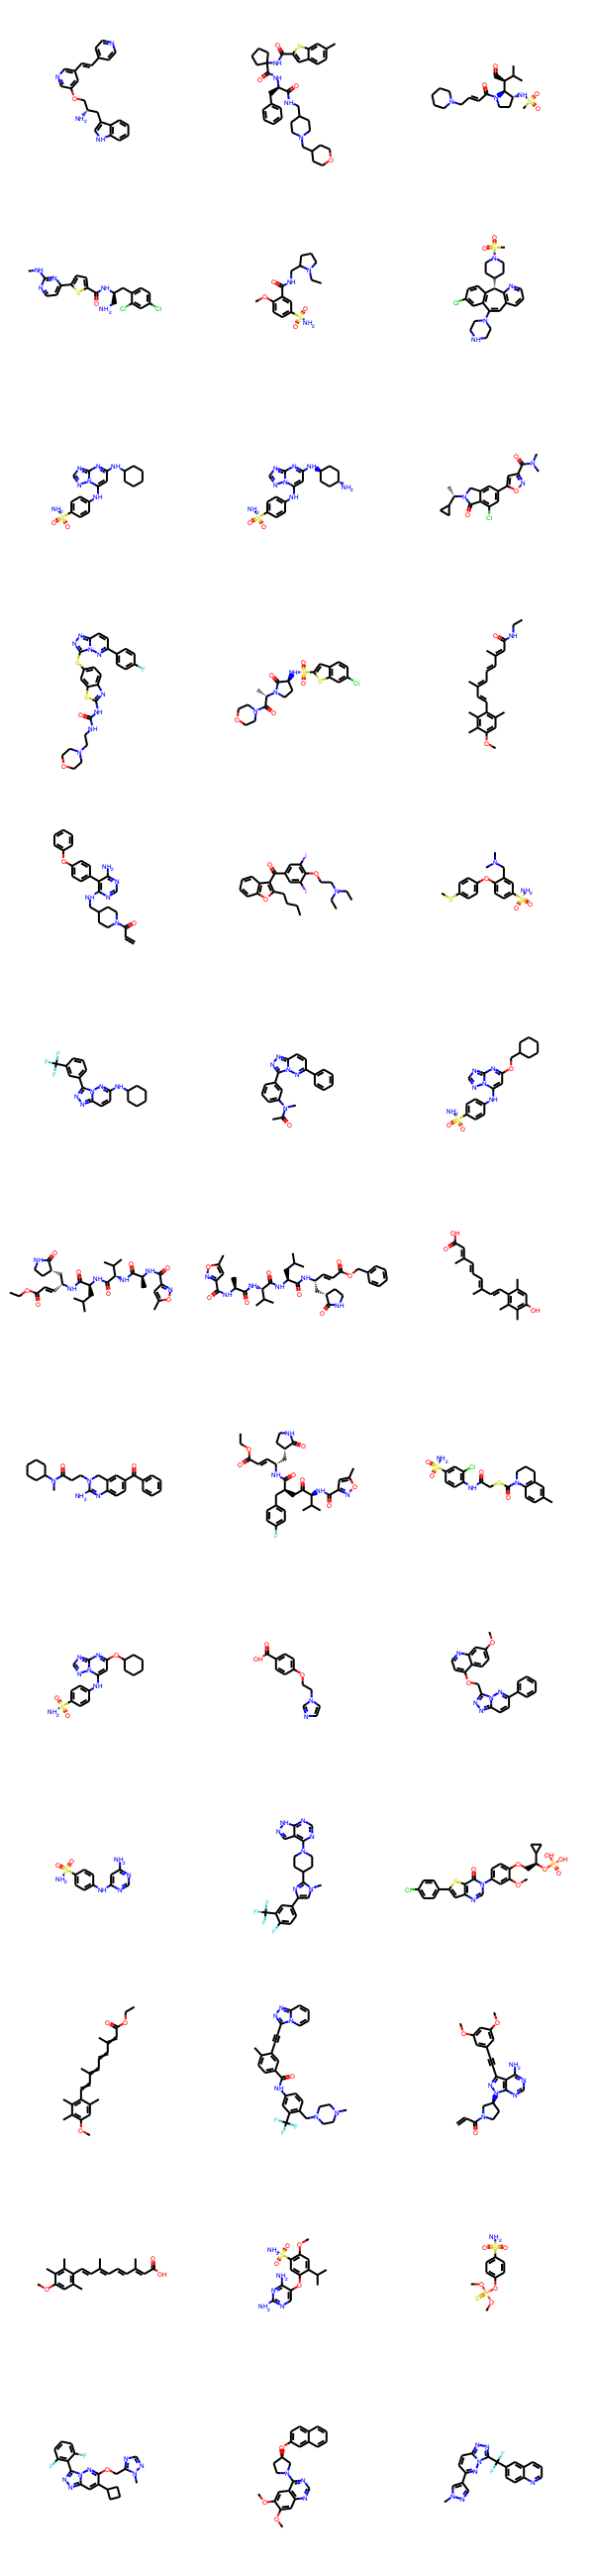

In [76]:
Draw.MolsToGridImage(list(df[(df.AvgABSel>0.5)&(df.SelD>0.5)&(df.pki_G>6.0)].ROMol))

## Load MACCS based RF  Models for CAMK2A/B/D/G

In [18]:
screen['MACCS']['CAMK2G'] = joblib.load('models/RF-MACCS-pki/CAMK2G/finalized_model_CAMK2G_FingerPrint.sav')
screen['MACCS']['CAMK2D'] = joblib.load('models/RF-MACCS-pki/CAMK2D/finalized_model_CAMK2D_RandomStratified.sav')
screen['MACCS']['CAMK2B'] = joblib.load('models/RF-MACCS-pki/CAMK2B/finalized_model_CAMK2B_RandomStratified.sav')
screen['MACCS']['CAMK2A'] = joblib.load('models/RF-MACCS-pki/CAMK2A/finalized_model_CAMK2A_Scaffold.sav')

In [19]:
def MAACS2FP(mol):
    fp = rdMolDescriptors.GetMACCSKeysFingerprint(mol)
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr    

In [22]:
from rdkit.Chem import rdMolDescriptors, DataStructs
df['MACCS_FP'] = [MAACS2FP(mol) for mol in df.ROMol]

In [24]:
df['MACCS_pki_G'] = screen['MACCS']['CAMK2G'].predict(np.array(list(df.MACCS_FP)))
df['MACCS_pki_D'] = screen['MACCS']['CAMK2D'].predict(np.array(list(df.MACCS_FP)))
df['MACCS_pki_B'] = screen['MACCS']['CAMK2B'].predict(np.array(list(df.MACCS_FP)))
df['MACCS_pki_A'] = screen['MACCS']['CAMK2A'].predict(np.array(list(df.MACCS_FP)))

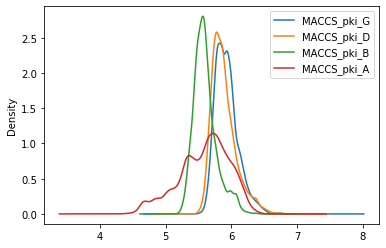

In [26]:
df[df.columns[-4:]].plot(kind='kde')

In [74]:
df['MACCS_SelB'] = df.MACCS_pki_G - df.MACCS_pki_B
df['MACCS_SelA'] = df.MACCS_pki_G - df.MACCS_pki_A
df['MACCS_SelD'] = df.MACCS_pki_G - df.MACCS_pki_D
df['MACCSAvgABSel'] = (df.MACCS_SelB + df.MACCS_SelA)*0.5

Text(0.5, 1.0, 'Morgan Fingerprint')

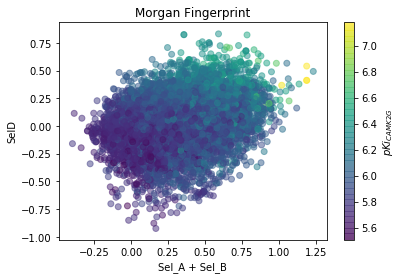

In [75]:
sc = plt.scatter(df.MACCSAvgABSel,df.MACCS_SelD,c=list(df.MACCS_pki_G),alpha=0.5)
plt.colorbar(sc,label='$pKi_{CAMK2G}$')
plt.xlabel('Sel_A + Sel_B')
plt.ylabel('SelD')
plt.title('Morgan Fingerprint')

/Users/leela.dodda/anaconda3/envs/deepchem/lib/python3.7/site-packages/rdkit/Chem/Draw/IPythonConsole.py:186: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  % (maxMols))


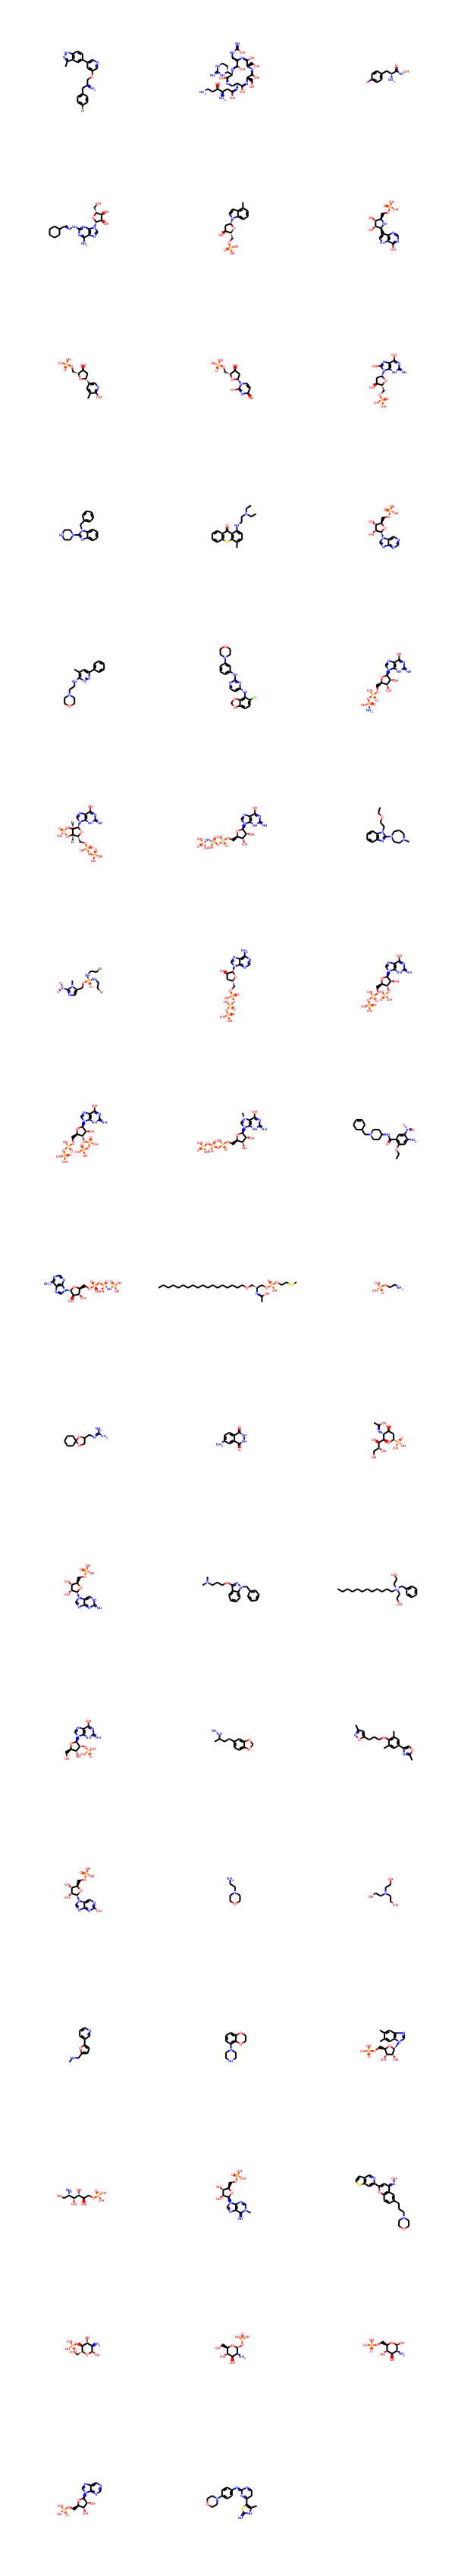

In [77]:
Draw.MolsToGridImage(list(df[(df.MACCSAvgABSel>0.5)&(df.MACCS_SelD>0.5)&(df.MACCS_pki_G>6.0)].ROMol))

## Load Pharmacopore model based RF  Models for CAMK2A/B/D/G

In [50]:
screen['Pharm2D']['CAMK2G'] = joblib.load('models/RF-Pharm2D-pki/CAMK2G/finalized_model_CAMK2G_Scaffold.sav')
screen['Pharm2D']['CAMK2D'] = joblib.load('models/RF-Pharm2D-pki/CAMK2D/finalized_model_CAMK2D_RandomStratified.sav')
screen['Pharm2D']['CAMK2B'] = joblib.load('models/RF-Pharm2D-pki/CAMK2B/finalized_model_CAMK2B_RandomStratified.sav')
screen['Pharm2D']['CAMK2A'] = joblib.load('models/RF-Pharm2D-pki/CAMK2A/finalized_model_CAMK2A_RandomStratified.sav')

In [51]:
from rdkit.Chem import rdMolDescriptors, DataStructs
from rdkit.Chem.Pharm2D import Gobbi_Pharm2D,Generate

def Pharm2D2FP(mol):
    fp = Generate.Gen2DFingerprint(mol,Gobbi_Pharm2D.factory)
    exp_fp = DataStructs.cDataStructs.ConvertToExplicit(fp)
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(exp_fp, arr)
    return arr    

In [52]:
df['Pharm2D_FP'] = [Pharm2D2FP(mol) for mol in df.ROMol]

In [53]:
df['Pharm2D_pki_G'] = screen['Pharm2D']['CAMK2G'].predict(np.array(list(df.Pharm2D_FP)))
df['Pharm2D_pki_D'] = screen['Pharm2D']['CAMK2D'].predict(np.array(list(df.Pharm2D_FP)))
df['Pharm2D_pki_B'] = screen['Pharm2D']['CAMK2B'].predict(np.array(list(df.Pharm2D_FP)))
df['Pharm2D_pki_A'] = screen['Pharm2D']['CAMK2A'].predict(np.array(list(df.Pharm2D_FP)))

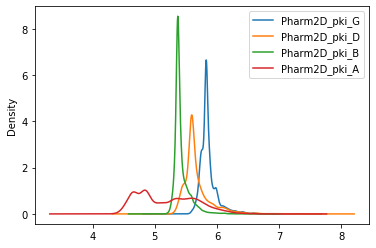

In [54]:
df[df.columns[-4:]].plot(kind='kde')

In [78]:
df['Pharm2D_SelB'] = df.Pharm2D_pki_G - df.Pharm2D_pki_B
df['Pharm2D_SelA'] = df.Pharm2D_pki_G - df.Pharm2D_pki_A
df['Pharm2D_SelD'] = df.Pharm2D_pki_G - df.Pharm2D_pki_D
df['Pharm2DAvgABSel'] = (df.Pharm2D_SelB + df.Pharm2D_SelA)*0.5

Text(0.5, 1.0, 'Morgan Fingerprint')

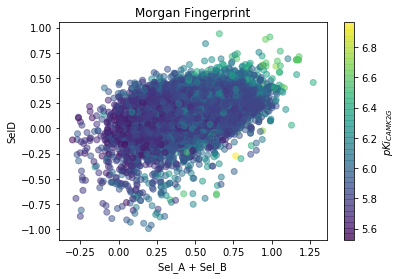

In [80]:
sc = plt.scatter(df.Pharm2DAvgABSel,df.Pharm2D_SelD,c=list(df.Pharm2D_pki_G),alpha=0.5)
plt.colorbar(sc,label='$pKi_{CAMK2G}$')
plt.xlabel('Sel_A + Sel_B')
plt.ylabel('SelD')
plt.title('Morgan Fingerprint')

/Users/leela.dodda/anaconda3/envs/deepchem/lib/python3.7/site-packages/rdkit/Chem/Draw/IPythonConsole.py:186: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  % (maxMols))


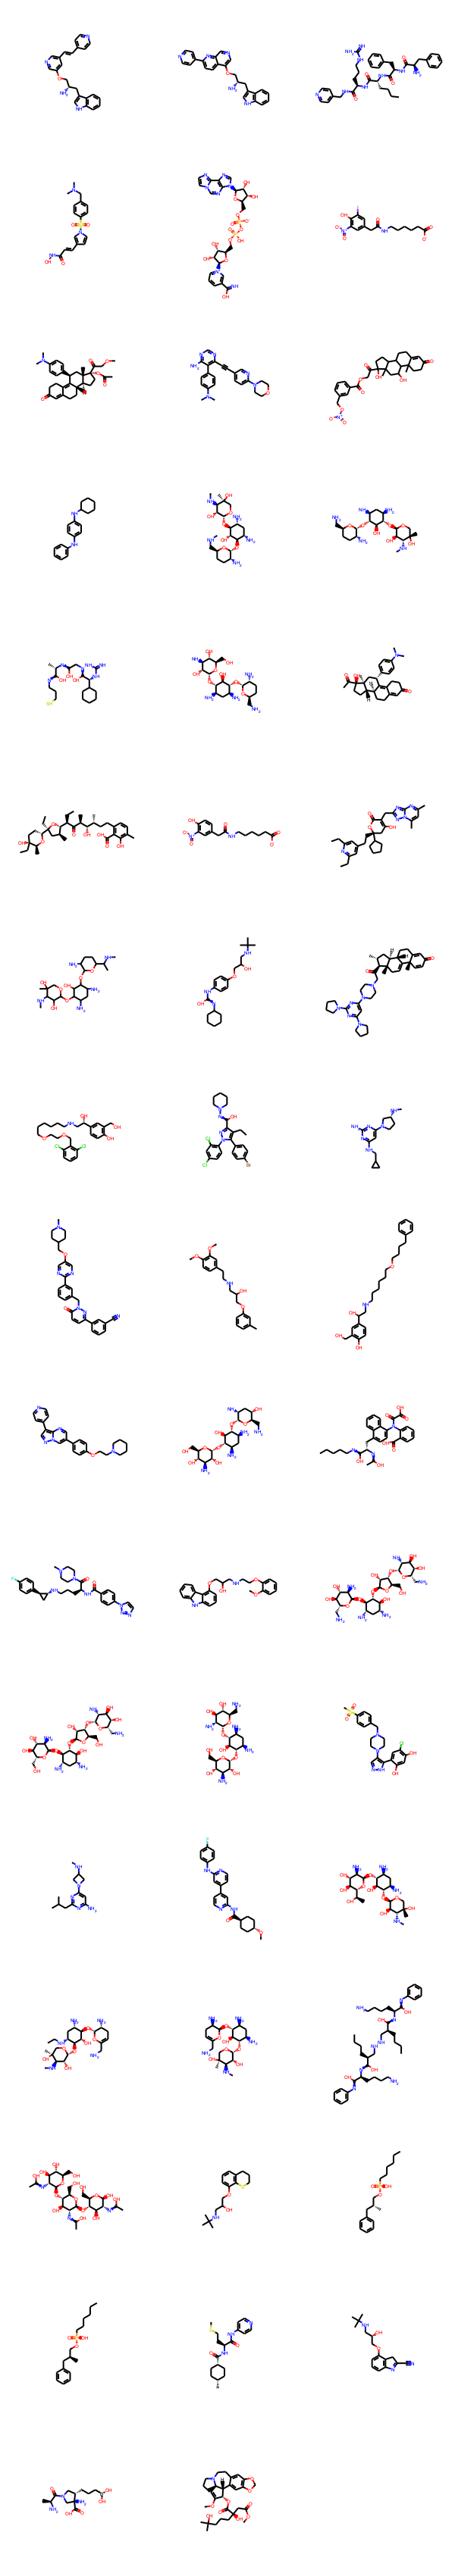

In [81]:
Draw.MolsToGridImage(list(df[(df.Pharm2DAvgABSel>0.5)&(df.Pharm2D_SelD>0.5)&(df.MACCS_pki_G>6.0)].ROMol))

## Collect all the molecules with Selectivity AB > 0.5 and Sel D> 0 

In [160]:
from rdkit.Chem import QED
df['QED'] = [QED.qed(m) for m in df.ROMol]

In [161]:
mols = []
mols = mols + list(df[(df.Pharm2D_SelA>0.5)&(df.Pharm2D_SelB>0.5)&(df.Pharm2D_SelD>0.5)&(df.Pharm2D_pki_G>6.0)].DATABASE_ID) 
mols = mols + list(df[(df.SelA>0.5)&(df.SelB>0.5)&(df.SelD>0.5)&(df.pki_G>6.0)].DATABASE_ID)
mols = mols + list(df[(df.MACCS_SelA>0.5)&(df.MACCS_SelB>0.5)&(df.MACCS_SelD>0.5)&(df.MACCS_pki_G>6.0)].DATABASE_ID)
mols = np.unique(mols)
PandasTools.WriteSDF(df[df.DATABASE_ID.isin(mols)],'lbvs_results/Sel_gt_0.5_and_pki_gt_6.sdf',molColName='ROMol',
    idName='DATABASE_ID',
    properties=df.columns)
mols = []
mols = mols + list(df[(df.Pharm2D_SelA>0.5)&(df.Pharm2D_SelB>0.5)&(df.Pharm2D_SelD>0.5)&(df.Pharm2D_pki_G>6.5)].DATABASE_ID) 
mols = mols + list(df[(df.SelA>0.5)&(df.SelB>0.5)&(df.SelD>0.5)&(df.pki_G>6.5)].DATABASE_ID)
mols = mols + list(df[(df.MACCS_SelA>0.5)&(df.MACCS_SelB>0.5)&(df.MACCS_SelD>0.5)&(df.MACCS_pki_G>6.5)].DATABASE_ID)
mols = np.unique(mols)
PandasTools.WriteSDF(df[df.DATABASE_ID.isin(mols)],'lbvs_results/Sel_gt_0.5_and_pki_gt_6p5.sdf',molColName='ROMol',
    idName='DATABASE_ID',
    properties=df.columns)

In [ ]:
PandasTools.WriteSDF(df,'lbvs_results/All_results.sdf',molColName='ROMol',
    idName='DATABASE_ID',
    properties=df.columns)

In [ ]:
mols = []
mols = mols + list(df[(df.Pharm2D_SelA>0.5)&(df.Pharm2D_SelB>0.5)&(df.Pharm2D_SelD>0.5)&(df.Pharm2D_pki_G>6.5)].DATABASE_ID) 
mols = mols + list(df[(df.SelA>0.5)&(df.SelB>0.5)&(df.SelD>0.5)&(df.pki_G>6.5)].DATABASE_ID)
mols = mols + list(df[(df.MACCS_SelA>0.5)&(df.MACCS_SelB>0.5)&(df.MACCS_SelD>0.5)&(df.MACCS_pki_G>6.5)].DATABASE_ID)
mols = np.unique(mols)
PandasTools.WriteSDF(df[df.DATABASE_ID.isin(mols)],'lbvs_results/Sel_gt_0.5_and_pki_gt_6p5.sdf',molColName='ROMol',
    idName='DATABASE_ID',
    properties=df.columns)

In [ ]:
ndf = df[df.DATABASE_ID.isin(mols)].sort_values(['QED'],ascending=False)
Draw.MolsToGridImage(list(ndf.ROMol),legends=['%s %.2f'%(r.DATABASE_ID,r.QED) for i,r in ndf.iterrows()])

In [ ]:
Draw.MolsToImage?

In [ ]:
ndf[ndf.DRUG_GROUPS.str.contains('approved')]